In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

**Importing preprocessed data**

In [13]:
df = pd.read_csv('../data/preprocessed_data.csv')
X = df.drop(['Segmentation'], axis=1)

## **Finding out number of clusters**

In [14]:
K = len(df['Segmentation'].unique()) 
K

4

**Elbow method**

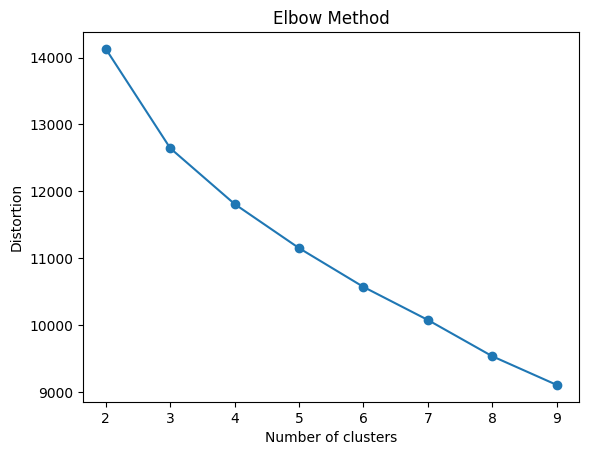

In [15]:
distortions = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=1000, random_state=42)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)


plt.plot(range(2, 10), distortions, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

## **Clustering**

In [16]:
kmeans = KMeans(n_clusters=K, max_iter=1000, n_init=100, init='k-means++', random_state=42, verbose=False)

labels = kmeans.fit_predict(X)

df_res = X.copy()
df_res["Cluster"] = labels

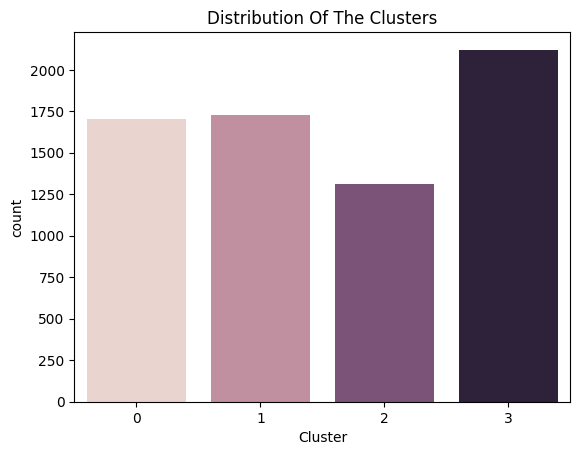

In [17]:
pl = sns.countplot(x='Cluster', data=df_res, hue='Cluster', legend=False)
pl.set_title("Distribution Of The Clusters")
plt.show()

### **Information about each cluster**

**Rescaling and decoding the data**

In [18]:
import pickle

with open('../pkl/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('../pkl/one_hot_encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)

In [19]:
cols = X.columns

rescaled = df_res.copy()
rescaled[cols] = scaler.inverse_transform(rescaled[cols]).round()

decoded = rescaled[df_res.columns[-8:]].copy()
decoded = pd.concat([
    pd.DataFrame(encoder.inverse_transform(rescaled[df_res.columns[:-8]]), columns=['Profession', 'Category']),
    decoded], axis=1)


decoded['Married'] = decoded['Married'].map({1: 'Yes', 0:'No'})
decoded['Graduated'] = decoded['Graduated'].map({1: 'Yes', 0:'No'})
decoded['Gender'] = decoded['Gender'].map({1: 'Female', 0:'Male'})
decoded['SpendingScore'] = decoded['SpendingScore'].map({0:'Low', 1: 'Average', 2: 'High'})

decoded

,Profession,Category,Gender,Married,Age,Graduated,WorkExperience,SpendingScore,FamilySize,Cluster
0,Healthcare,Category 4,Male,No,22.0,No,1.0,Low,4.0,0
1,Engineer,Category 4,Female,Yes,38.0,Yes,3.0,Average,3.0,0
2,Engineer,Category 6,Female,Yes,67.0,Yes,1.0,Low,1.0,1
3,Lawyer,Category 6,Male,Yes,67.0,Yes,0.0,High,2.0,1
4,Entertainment,Category 6,Female,Yes,40.0,Yes,4.0,High,6.0,1
...,...,...,...,...,...,...,...,...,...,...
6859,Artist,Category 6,Male,Yes,41.0,Yes,0.0,High,5.0,3
6860,Executive,Category 4,Male,No,35.0,No,3.0,Low,4.0,0
6861,Healthcare,Category 6,Female,No,33.0,Yes,1.0,Low,1.0,2
6862,Healthcare,Category 6,Female,No,27.0,Yes,1.0,Low,4.0,2


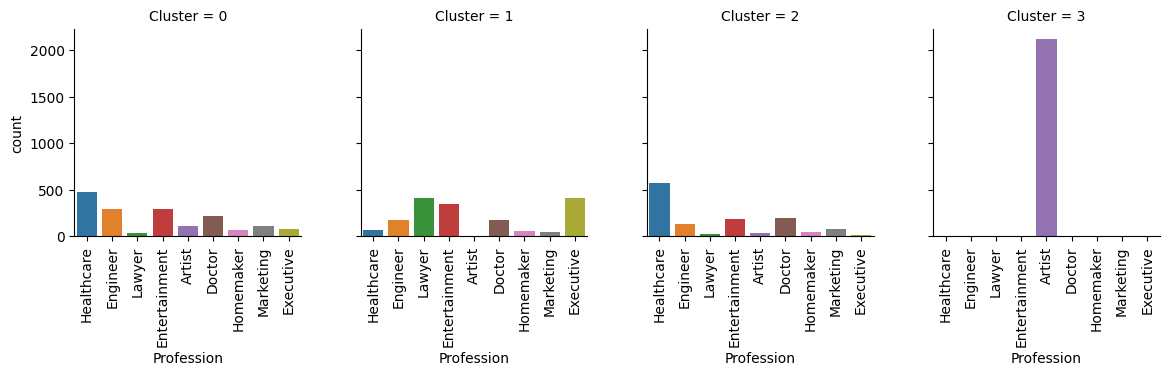

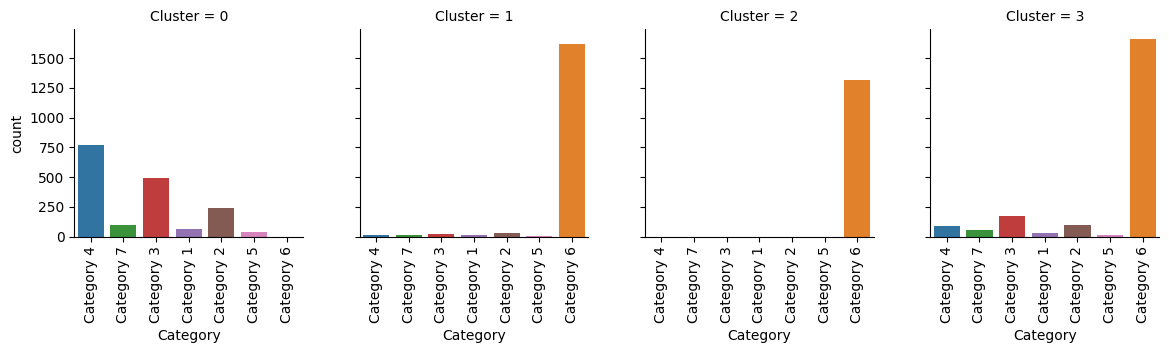

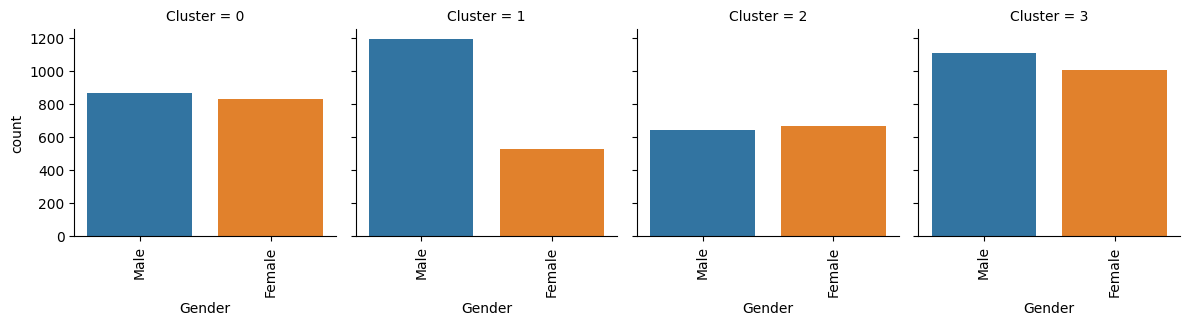

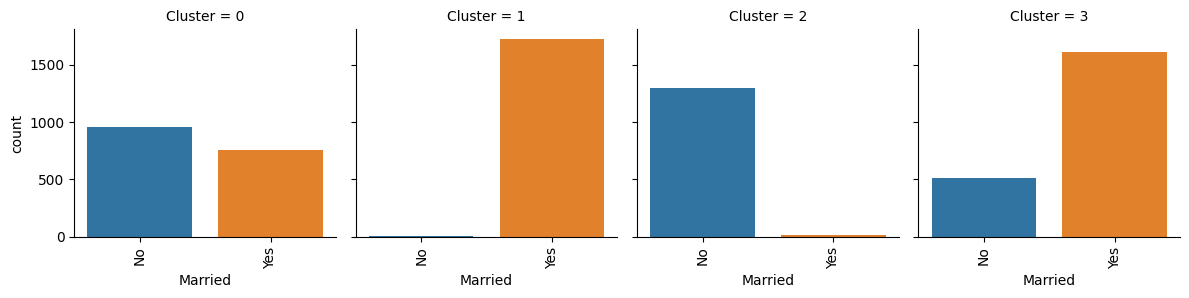

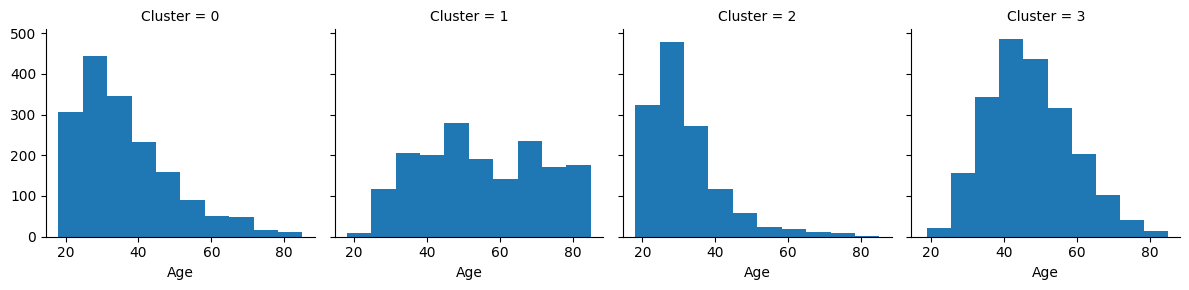

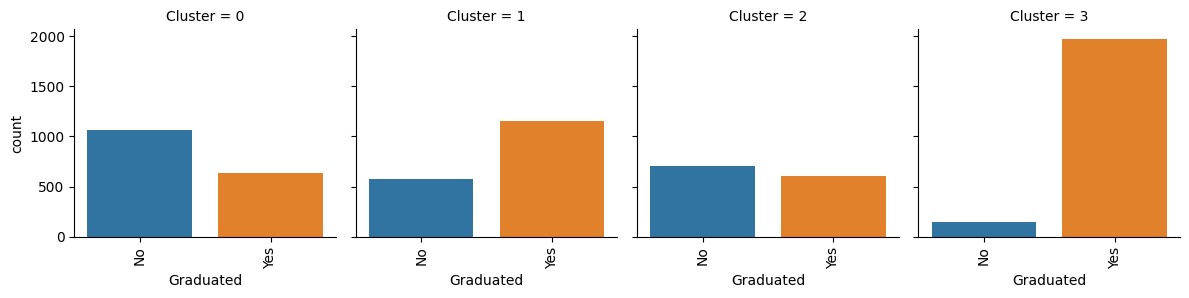

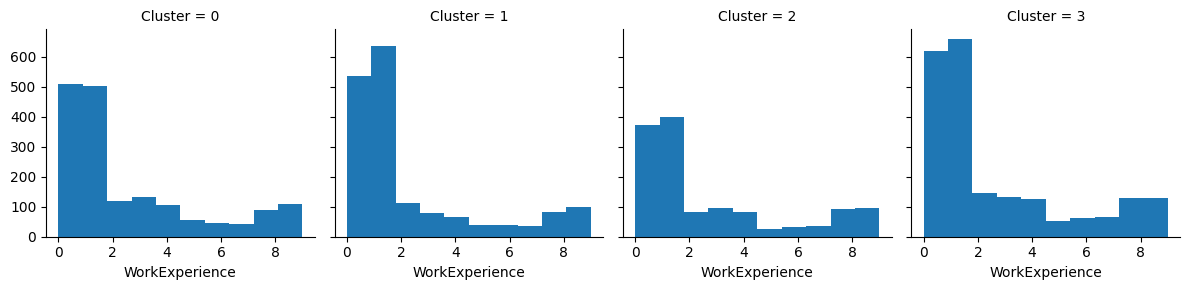

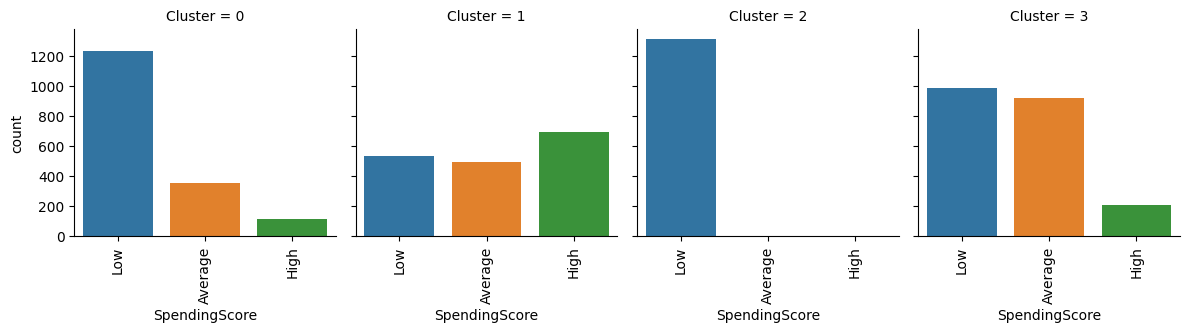

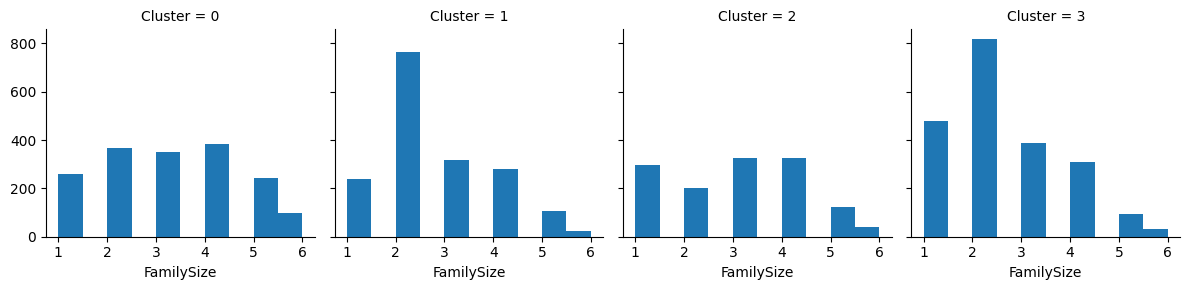

In [20]:
for c in decoded.drop(['Cluster'], axis=1):
    
    if decoded[c].dtype == 'object':
        grid = sns.FacetGrid(decoded, col='Cluster', hue=c)
        grid = grid.map(sns.countplot, c)
        for axes in grid.axes.flat:
            axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
    else:
        grid = sns.FacetGrid(decoded, col='Cluster')
        grid = grid.map(plt.hist, c)

    plt.show()

### **Results visualization**

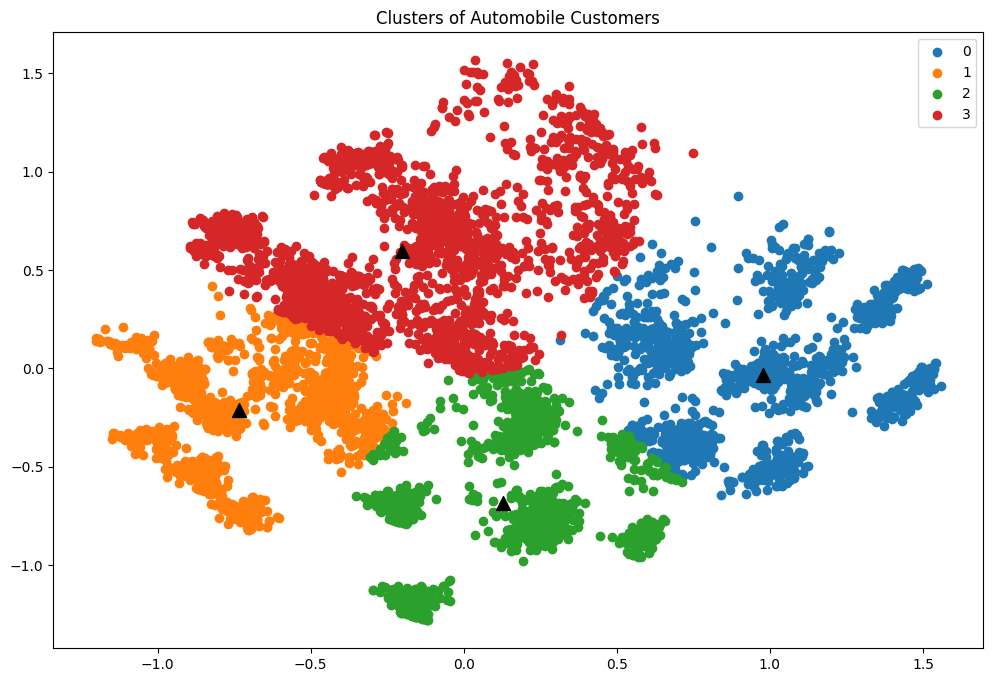

In [21]:
pca = PCA(n_components=2).fit_transform(X)

kmeans_pca = KMeans(n_clusters=K, max_iter=1000, n_init=100, init='k-means++', random_state=42, verbose=False)
labels = kmeans_pca.fit_predict(pca)

pca_res = pd.DataFrame(pca.copy())
pca_res["Cluster"] = labels

centroids = kmeans_pca.cluster_centers_
u_labels = np.unique(labels)


plt.figure(figsize=(12,8))
for i in u_labels:
    mask = (pca_res["Cluster"] == i)
    plt.scatter(pca_res.loc[mask][0], pca_res.loc[mask][1], label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 100, color = 'k', marker="^")
plt.title('Clusters of Automobile Customers')
plt.legend()
plt.show()

# **Exporting the model**

In [22]:
import pickle

pickle.dump(kmeans, open('../pkl/kmeans.pkl', 'wb'))